In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns

from gglm.glm.wglm import WGLM
from gglm.critic import Critic
from kernel.fun import KernelFun
from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

In [2]:
npz = np.load('./fr_mismatch.npz')
t, stim, mask_spikes_te, u_spk_mean_te, mask_spikes_fr, u_spk_mean_fr  = npz['t'], npz['stim'], npz['mask_spikes_te'], npz['u_spk_mean_te'], npz['mask_spikes_fr'], npz['u_spk_mean_fr']
u_te, u_fr = npz['u_te'], npz['u_fr']
r_te, r_fr = npz['r_te'], npz['r_fr']
u0_ml, eta_vals_ml = npz['glm_u0'], npz['glm_eta']

mask_spikes = np.concatenate((mask_spikes_te, mask_spikes_fr), axis=1)
y = np.concatenate((np.ones(mask_spikes_te.shape[1]), np.zeros(mask_spikes_fr.shape[1])))
u = np.concatenate((u_te, u_fr), axis=1)
r = np.concatenate((r_te, r_fr), axis=1)

Starting gradient ascent... 

 Iteration 147 of 200 | Elapsed time: 4.59 seconds | objective=270316.84
 
 Iteration 147 of 200 | Converged | Elapsed time: 0.0765 minutes | Log posterior is monotonic 

None


(array([52., 21., 10.,  8.,  4.,  1.,  1.,  1.,  1.,  1.]),
 array([-22901.9324156 ,  -8805.88371198,   5290.16499164,  19386.21369526,
         33482.26239888,  47578.3111025 ,  61674.35980613,  75770.40850975,
         89866.45721337, 103962.50591699, 118058.55462061]),
 <a list of 10 Patch objects>)

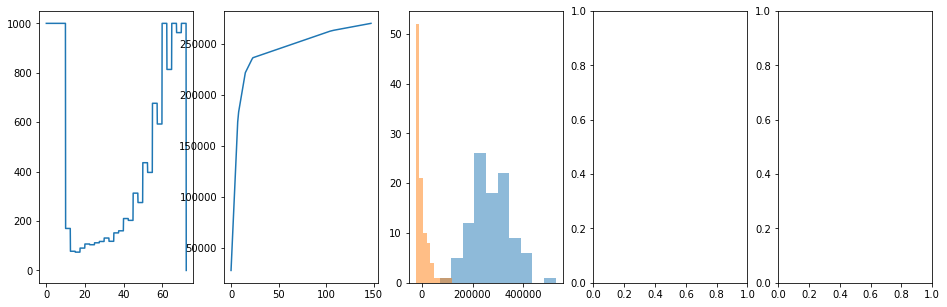

In [13]:
# tbins = np.array([-512, -256, -128, -64, -32, -16, -8, -4, -2, 0, 2, 4, 8, 16, 32, 64, 128, 256, 512])
tbins = np.arange(0, 75, 2.5)
# tbins = np.array([0, 2, 4, 8, 16, 32, 64, 128, 256, 512])

# clip_theta = 7e-3
# 
# clip_theta = 3e2

# clip_theta = 2e-2
# u_kernel = KernelRect(tbins, np.ones(len(tbins) - 1) * clip_theta)
# critic = Critic(u_kernel)

# clip_theta = 3e1
# u_spk_kernel = KernelRect(tbins, np.ones(len(tbins) - 1) * clip_theta * 1e-1)
# critic = Critic(u_spk_kernel=u_spk_kernel)

# # clip_theta = 2e2 # soft correction
# clip_theta = 10e2 # soft correction
# critic = Critic(u_kernel=None, beta=np.array([1e-4]), features=['r_spk'])

# clip_theta = 10e2
# r_kernel = KernelRect(tbins, np.ones(len(tbins) - 1) * clip_theta * 1e-1)
# critic = Critic(r_kernel=r_kernel)

clip_theta = 10e2
r_spk_kernel = KernelRect(tbins, np.ones(len(tbins) - 1) * clip_theta * 1e-1)
critic = Critic(r_spk_kernel=r_spk_kernel)

newton_kwargs_critic = dict(max_iterations=200, learning_rate=1e0, use_hessian=False, clip_theta=clip_theta)
optimizer = critic.fit(t, mask_spikes, u, r, y, u0=u0_ml, newton_kwargs=newton_kwargs_critic, verbose=True)

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 5), ncols=5)
# eta_ml.plot(ax=ax0, invert_values=True)
# critic.u_kernel.plot(ax=ax0, invert_values=False)
# critic.u_spk_kernel.plot(ax=ax0, invert_values=False)
# critic.r_kernel.plot(ax=ax0, invert_values=False)
critic.r_spk_kernel.plot(ax=ax0, invert_values=False)
print(critic.beta)
ax1.plot(optimizer.obj_iterations)
# ax2.plot(optimizer.obj_iterations - optimizer.metrics_iterations['c_w_distance'])
# ax3.plot(optimizer.metrics_iterations['c_w_distance'])
# ax4.plot(optimizer.metrics_iterations['w_distance'])

a0 = critic.transform(t, mask_spikes, u, r, u0=u0_ml)
a0 = a0 - np.mean(a0[y == 0]) 

ax2.hist(a0[y == 1], alpha=0.5)
ax2.hist(a0[y == 0], alpha=0.5)

In [14]:
a_te = critic.r_spk_kernel.convolve_continuous(t, mask_spikes_te)
a_fr = critic.r_spk_kernel.convolve_continuous(t, mask_spikes_fr)

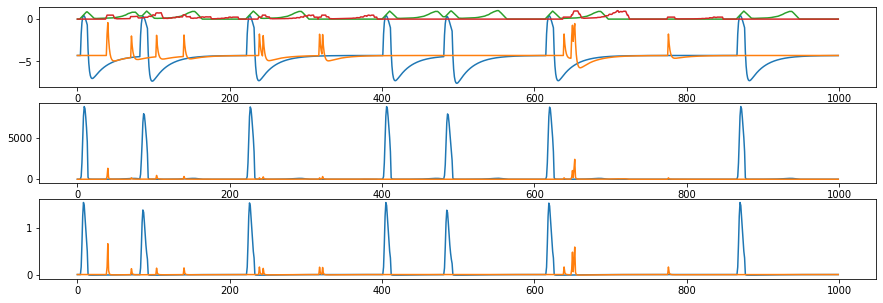

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), nrows=3)
ax1.plot(u_te[:, 0])
ax1.plot(u_fr[:, 0])
ax1.plot(a_te[:, 0] / np.max(np.abs(a_te[:, 0])))
ax1.plot(a_fr[:, 0] / np.max(np.abs(a_fr[:, 0])))
ax2.plot((a_te * r_te)[:, 0])
ax2.plot((a_fr * r_fr)[:, 0])
ax3.plot(r_te[:, 0])
ax3.plot(r_fr[:, 0])
# ax.plot(mask_spikes_te[:, 0])

Starting gradient ascent... 

 Iteration 29 of 30 | Elapsed time: 48.02 seconds | objective=-41834.01
 
 Not converged after 30 iterations. Elapsed time: 0.8004 minutes | Log posterior is monotonic 



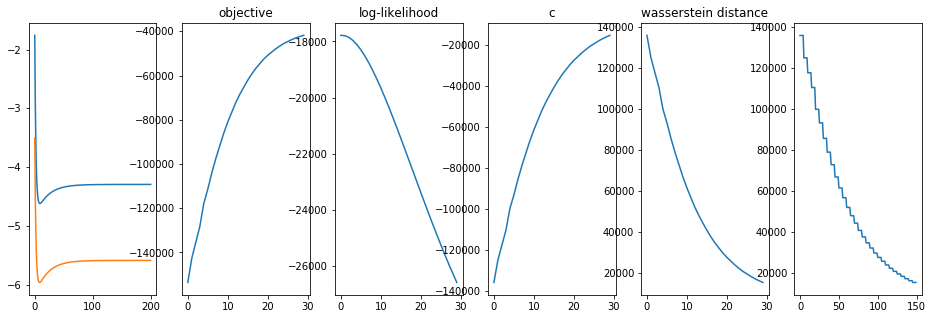

In [16]:
eta_ml = KernelFun.exponential(tau=np.array([2, 20]), coefs=eta_vals_ml.copy())

wglm = WGLM(u0=u0_ml, eta=eta_ml.copy(), critic=critic.copy())

newton_kwargs_critic = dict(max_iterations=20, learning_rate=1e0, use_hessian=False, warm_up_iterations=3, 
                            clip_theta=clip_theta)
newton_kwargs = dict(max_iterations=30, learning_rate=1e-1, use_hessian=True, stop_cond=1e-12)
optimizer = wglm.fit(t, mask_spikes, newton_kwargs=newton_kwargs, verbose=True, n_samples_fr=200,
            newton_kwargs_critic=newton_kwargs_critic)

stim_naive = np.zeros((len(t), 200))
u_new_fr, r_new_fr, mask_spikes_new_fr = wglm.sample(t, shape=(100,))
u_new_te, r_new_te = wglm.simulate_subthreshold(t, stim_naive, mask_spikes_te)

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(16, 5), ncols=6)
# eta_ml.plot(ax=ax0, invert_values=True)
# wglm.eta.plot(ax=ax0, invert_values=True)
t_ = np.arange(eta_ml.support[0], eta_ml.support[1], .1)
a = -eta_ml.interpolate(t_) - u0_ml
b = -wglm.eta.interpolate(t_) - wglm.u0
ax0.plot(t_, a)
ax0.plot(t_, b)
ax1.plot(optimizer.obj_iterations)
ax2.plot(optimizer.obj_iterations - optimizer.metrics_iterations['c_w_distance'])
ax3.plot(optimizer.metrics_iterations['c_w_distance'])
ax4.plot(optimizer.metrics_iterations['w_distance'])
ax5.plot(np.concatenate((optimizer.metrics_iterations['w_distance2'])))

ax1.set_title('objective')
ax2.set_title('log-likelihood')
ax3.set_title('c')
ax4.set_title('wasserstein distance')

if wglm.critic.u_kernel is not None:
    fig, (ax0, ax1) = plt.subplots(figsize=(16, 5), ncols=2)
    wglm.critic.u_kernel.plot(ax=ax0, invert_values=True)

(array([ 2.,  5., 18., 27.,  0., 15., 16.,  7.,  5.,  5.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

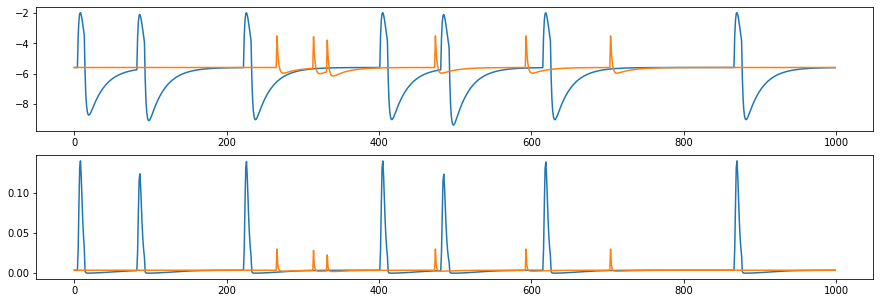

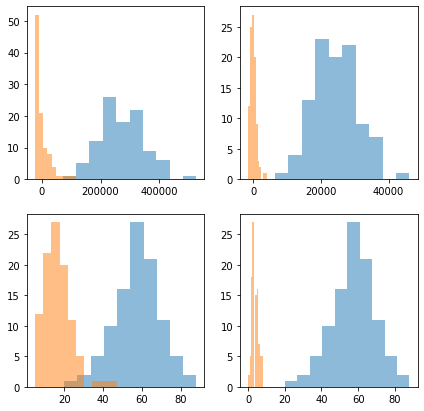

In [17]:
a = critic.transform(t, mask_spikes, u, r, u0=u0_ml)
a_new_te = wglm.critic.transform(t, mask_spikes_te, u_new_te, r_new_te, u0=wglm.u0)
a_new_fr = wglm.critic.transform(t, mask_spikes_fr, u_new_fr, r_new_fr, u0=wglm.u0)
a = a - np.mean(a[y == 0])
a_new_te = a_new_te - np.mean(a_new_fr)
a_new_fr = a_new_fr - np.mean(a_new_fr)

n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
n_spikes_new_fr = np.sum(mask_spikes_new_fr, 0)

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), nrows=2)
ax1.plot(u_new_te[:, 0])
ax1.plot(u_new_fr[:, 0])
ax2.plot(r_new_te[:, 0])
ax2.plot(r_new_fr[:, 0])
# ax.plot(mask_spikes_te[:, 0])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax1.hist(a[y == 1], alpha=0.5)
ax1.hist(a[y == 0], alpha=0.5)
ax2.hist(a_new_te, alpha=0.5)
ax2.hist(a_new_fr, alpha=0.5)

ax3.hist(n_spikes_te, alpha=0.5)
ax3.hist(n_spikes_fr, alpha=0.5)
ax4.hist(n_spikes_te, alpha=0.5)
ax4.hist(n_spikes_new_fr, alpha=0.5)